Pydantic


In [1]:
from typing_extensions import TypedDict

class State(TypedDict):
    xyz :str
    abc :str

In [2]:
from langgraph.graph import StateGraph ,END , START
from pydantic import BaseModel

class OverallState(BaseModel):
    a : str 

def node(State:OverallState):
    return {"a":'hi I am Monish'}



In [3]:
builder = StateGraph(OverallState)
builder.add_node(node)
builder.add_edge(START,"node")
builder.add_edge("node",END)

graph = builder.compile()

graph.invoke({'a':"hi"})

{'a': 'hi I am Monish'}

In [4]:
try: 
    graph.invoke({"a":1223})

except Exception as e:
    print("Exception was raised ")

Exception was raised 


## Multiple Nodes- Run time validation

Run-time validation will also work in a multi-node graph. In the example below bad_node updates a to an integer.

Because run-time validation occurs on inputs, the validation error will occur when ok_node is called (not when bad_node returns an update to the state which is inconsistent with the schema).

In [5]:
from langgraph.graph import StateGraph,START,END
from typing_extensions import TypedDict
from pydantic import BaseModel

class OverallState(BaseModel):
    a : str


def bad_node(state:OverallState):
    return {"a":1234}


def ok_node(state:OverallState):
    return{'a':'goodbye'}



builder = StateGraph(OverallState)
builder.add_node(bad_node)
builder.add_node(ok_node)
builder.add_edge(START,'bad_node')
builder.add_edge('bad_node',"ok_node")
builder.add_edge("ok_node",END)
graph = builder.compile()

In [6]:
# Test the graph with a valid input
try:
    graph.invoke({"a": "Moni"})
except Exception as e:
    print("An exception was raised because bad_node sets `a` to an integer.")
    print(e)

An exception was raised because bad_node sets `a` to an integer.
1 validation error for OverallState
a
  Input should be a valid string [type=string_type, input_value=1234, input_type=int]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type


### Prompt Chaining
Prompt chaining decomposes a task into a sequence of steps, where each LLM call processes the output of the previous one. You can add programmatic checks on any intermediate steps to ensure that the process is still on track.

When to use this workflow: This workflow is ideal for situations where the task can be easily and cleanly decomposed into fixed subtasks. The main goal is to trade off latency for higher accuracy, by making each LLM call an easier task.

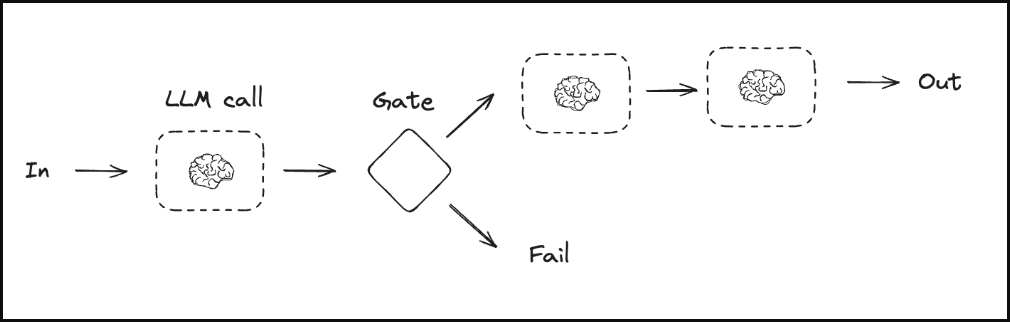

In [7]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen-2.5-32b")
result=llm.invoke("You alright?")
result



AIMessage(content="I'm good, thanks for asking! How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 32, 'total_tokens': 48, 'completion_time': 0.08, 'prompt_time': 0.003900848, 'queue_time': 0.052785229, 'total_time': 0.083900848}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-4ff373dc-f592-4ebf-8ffb-45ba8767e524-0', usage_metadata={'input_tokens': 32, 'output_tokens': 16, 'total_tokens': 48})

In [8]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image , display

class State(TypedDict):
    topic : str 
    joke: str
    improved_joke: str
    final_joke : str




In [9]:
def generate_joke(state:State):
    """First LLM Generate a joke"""
    msg = llm.invoke(f"write a short joke about {state['topic']}")
    return {"joke":msg.content}

def check_punchline(state:State):
    """gate function if the joke has punchline or not"""
    if "?" or '!' in state['joke']:
        return "Fail"
    return 'pass'

def improve_joke(state:State):
    """second LLM call to improve joke """
    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke":msg.content}

def polish_joke(state:State):
    """third LLM call to polish joke """
    msg = llm.invoke(f"add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke":msg.content}

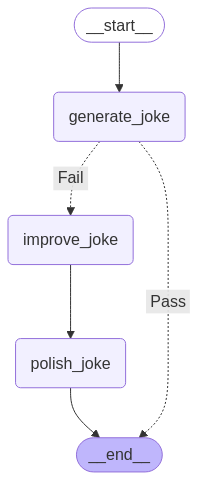

In [10]:
workflow = StateGraph(State)

#nodes
workflow.add_node('generate_joke',generate_joke)
workflow.add_node('improve_joke',improve_joke)
workflow.add_node('polish_joke',polish_joke)

#Add edges 
workflow.add_edge(START,'generate_joke')
workflow.add_conditional_edges("generate_joke",check_punchline,{'Fail':'improve_joke','Pass':END})
workflow.add_edge('improve_joke','polish_joke')
workflow.add_edge('polish_joke',END)

chain = workflow.compile()

display(Image(chain.get_graph().draw_mermaid_png()))

In [11]:
state = chain.invoke({'topic':"AI"})
state

{'topic': 'AI',
 'joke': 'Why did the AI go to the doctor?\n\nBecause it had a virus and it needed a byte to eat!',
 'improved_joke': 'Why did the AI go to the doctor?\n\nBecause it had a virus and it needed a byte to eat! Plus, it was feeling a little byte out of sorts—like it needed some code to crack!',
 'final_joke': 'Why did the AI go to the doctor?\n\nBecause it had a virus and it needed a byte to eat! Plus, it was feeling a little byte out of sorts—like it needed some code to crack! But to everyone\'s surprise, the doctor diagnosed it with a case of "human empathy overload." It turned out the AI had been watching too many romantic comedies and just needed a good cry and a heart-to-heart chat to feel better!'}

### Parallelization¶
With parallelization, LLMs work simultaneously on a task:

LLMs can sometimes work simultaneously on a task and have their outputs aggregated programmatically. This workflow, parallelization, manifests in two key variations: Sectioning: Breaking a task into independent subtasks run in parallel. Voting: Running the same task multiple times to get diverse outputs.

When to use this workflow: Parallelization is effective when the divided subtasks can be parallelized for speed, or when multiple perspectives or attempts are needed for higher confidence results. For complex tasks with multiple considerations, LLMs generally perform better when each consideration is handled by a separate LLM call, allowing focused attention on each specific aspect.

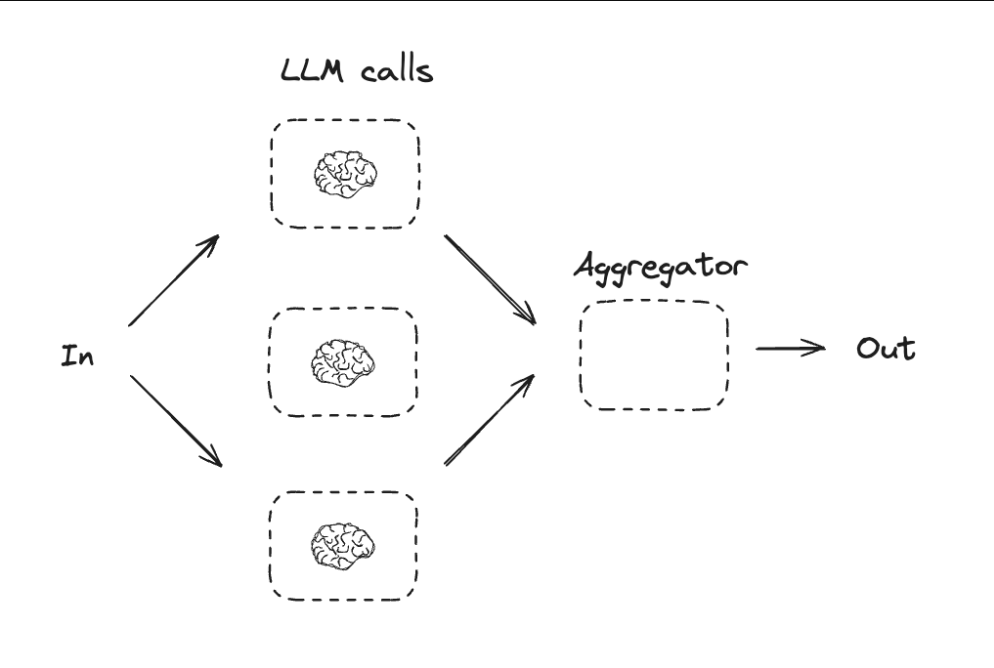

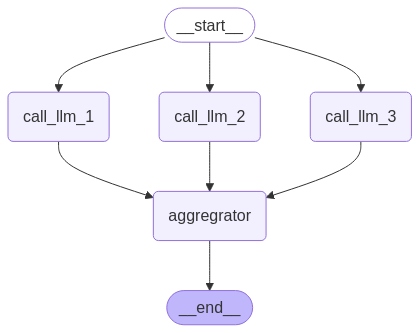

here is a story,joke,poem about Lion

STORY:
Once upon a time, in the heart of the vast Serengeti, there lived a lion named Kopa. Kopa wasn't just any lion; he was the prince of his pride, destined to become the next king of the entire savanna. His golden mane shone like the sun, and his roar echoed across the plains, making the grasses bow in respect. 

Kopa was different from other cubs. He was curious and brave, always eager to learn and explore. His mother, Queen Sarabi, and his father, King Mufasa, saw promise in him, but they also knew that leading a pride wasn't just about brawn; it was about wisdom and compassion. They taught him that every creature in the savanna had a role to play, and that true leadership meant protecting not just his own, but all life on the land.

As Kopa grew, he formed a special bond with a young hyena named Tama. Unlike the other hyenas who roamed the savanna, Tama's family had been pushed out of the clan by the harsh and cruel leader, Shenzi. Tama and 

In [12]:
class State(TypedDict):
    topic:str
    joke : str
    story: str
    poem : str
    combined_output:str

def call_llm_1(state: State):
    '''First llm call to generate initial joke'''

    msg = llm.invoke(f'write a funny joke about {state['topic']}')
    return {'joke':msg.content}

def call_llm_2 (state: State):
    '''Second llm call to generate story'''
    msg = llm.invoke(f'write a interesting story about {state["topic"]}')
    return {'story':msg.content}

def call_llm_3 (state: State):
    '''Third llm call to generate poem'''
    msg = llm.invoke(f'write a melodic poem about {state["topic"]}')
    return {'poem':msg.content}

def aggregator(state:State):
    '''Aggregator function to combine outputs from all llm calls'''

    combined = f"here is a story,joke,poem about {state['topic']}\n\n"
    combined += f'STORY:\n{state["story"]}\n\n'
    combined += f'JOKE:\n{state['joke']}\n\n'
    combined += f'POEM:\n{state['poem']}\n\n'
    return {'combined_output':combined}

parallel_builder = StateGraph(State)

#nodes 
parallel_builder.add_node('call_llm_1',call_llm_1)
parallel_builder.add_node('call_llm_2',call_llm_2)
parallel_builder.add_node('call_llm_3',call_llm_3)
parallel_builder.add_node('aggregrator',aggregator)

#edges
parallel_builder.add_edge(START,'call_llm_1')
parallel_builder.add_edge(START,'call_llm_2')
parallel_builder.add_edge(START,'call_llm_3')
parallel_builder.add_edge("call_llm_1","aggregrator")
parallel_builder.add_edge("call_llm_2","aggregrator")
parallel_builder.add_edge("call_llm_3","aggregrator")
parallel_builder.add_edge('aggregrator',END)
parallel_workflow = parallel_builder.compile()

display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

state = parallel_workflow.invoke({'topic':"Lion"})
print(state["combined_output"])

### Routing
Routing classifies an input and directs it to a specialized followup task. This workflow allows for separation of concerns, and building more specialized prompts. Without this workflow, optimizing for one kind of input can hurt performance on other inputs.

When to use this workflow: Routing works well for complex tasks where there are distinct categories that are better handled separately, and where classification can be handled accurately, either by an LLM or a more traditional classification model/algorithm.

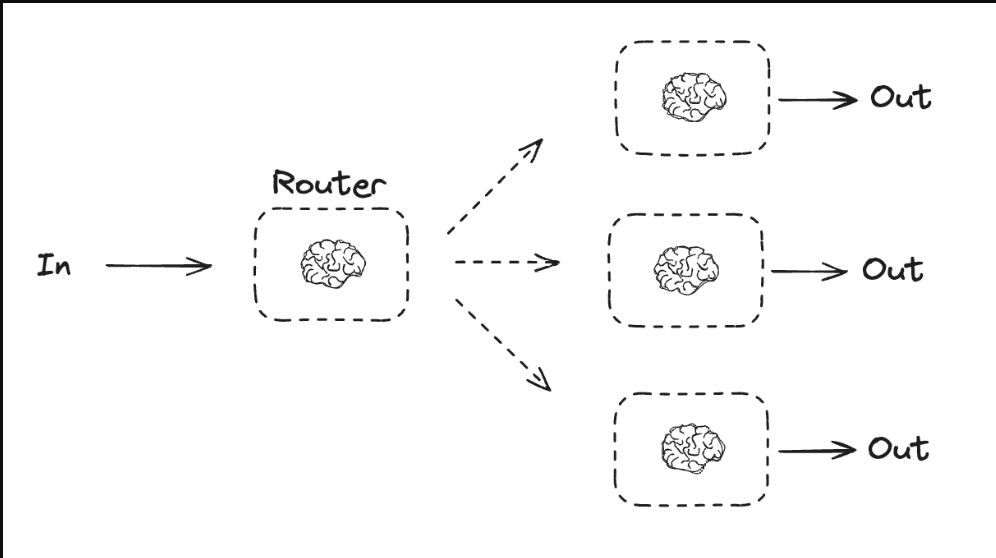

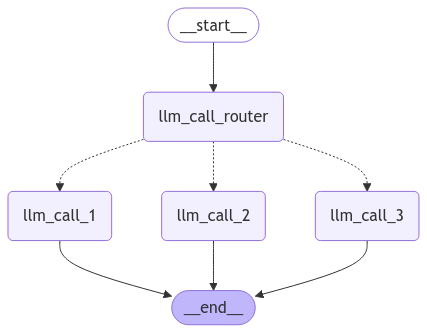

LLM call 2 is called
Why don't cats play poker in the wild? Because there are too many cheetahs!


In [13]:
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage


# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


# State
class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    print("LLM call 2 is called")

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}


# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"


# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

### Orchestrator-Worker
In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.

When to use this workflow: This workflow is well-suited for complex tasks where you can’t predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it’s topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

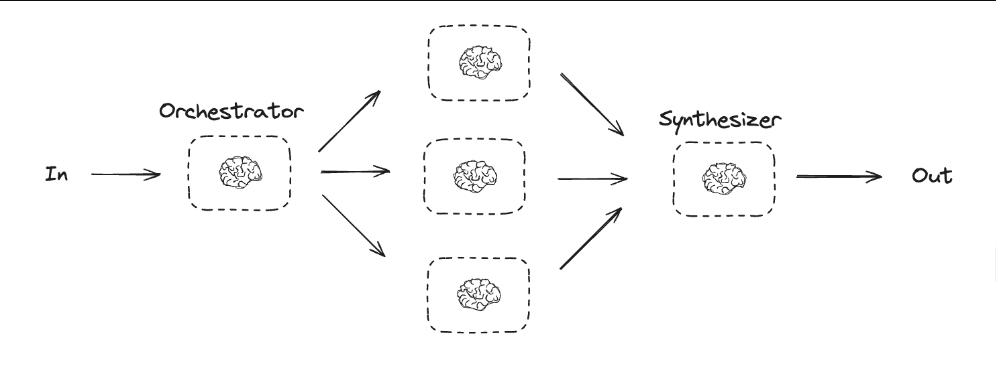

In [14]:

from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

### Creating Workers in LangGraph

Because orchestrator-worker workflows are common, LangGraph has the Send API to support this. It lets you dynamically create worker nodes and send each one a specific input. Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output. As you can see below, we iterate over a list of sections and Send each to a worker node. 

In [15]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    print("Report Sections:",report_sections)

    return {"sections": report_sections.sections}

def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]


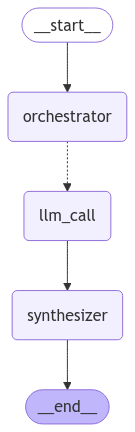

Report Sections: sections=[Section(name='Introduction', description='An overview of Agentic AI RAGs, what they are, and their importance in the field of artificial intelligence.'), Section(name='Theoretical Foundations', description='A deep dive into the theoretical underpinnings of Agentic AI RAGs, including key concepts and principles.'), Section(name='Applications', description='Examples of how Agentic AI RAGs are being used in various industries and the impact they have.'), Section(name='Challenges and Limitations', description='Exploration of the challenges and limitations associated with Agentic AI RAGs and how they are being addressed.'), Section(name='Future Directions', description='Potential future developments and research directions for Agentic AI RAGs.'), Section(name='Conclusion', description="Summary of the report's findings and the overall significance of Agentic AI RAGs.")]


## Introduction

Agentic AI RAGs, or Retrieval-Augmented Generation systems, represent a significant advancement in the field of artificial intelligence, merging the capabilities of retrieval-based and generative models. These systems are designed to enhance the accuracy and context-awareness of AI responses by integrating large databases or knowledge bases into the generative process. Agentic AI RAGs are not just about generating text based on statistical patterns but also about leveraging structured data to provide more informed and precise outputs. This approach is crucial as it allows AI systems to perform better in tasks that require a deep understanding of specific domains, such as legal, medical, or technical advice.

The importance of Agentic AI RAGs lies in their ability to bridge the gap between data retrieval and content generation, thus offering more reliable and contextually relevant information. As traditional retrieval models can sometimes lack the nuance and creativity of human language, and generative models can produce information that is not always accurate or factually grounded, RAG systems aim to provide the best of both worlds. This makes them particularly valuable in applications where precision and trustworthiness are paramount, such as customer service, content creation, and expert systems. By continuously refining their approach to integrating knowledge into text generation, Agentic AI RAGs are leading the way in making AI interactions more effective and user-friendly.

---

### Theoretical Foundations

The theoretical underpinnings of Agentic AI RAGs (Retrieval-Augmented Generation) are rooted in principles of cognitive science, information retrieval, and machine learning. At its core, Agentic AI RAGs leverage the capability of artificial intelligence to not only generate content but also retrieve relevant information to augment its output. This dual capability is achieved through the integration of retrieval models and generative models.

#### Key Concepts

- **Retrieval Models**: These models are designed to search and retrieve relevant documents or information from a large corpus. They are essential in the context of Agentic AI RAGs as they provide the AI with the ability to access and utilize external knowledge during the generation process.

- **Generative Models**: Generative models are responsible for creating new content based on patterns learned from data. In Agentic AI RAGs, these models generate responses or outputs, often incorporating the information retrieved by the retrieval models.

- **Agentic Behavior**: This refers to the autonomous decision-making capability within AI, enabling it to act purposefully and strategically. In Agentic AI RAGs, this manifests as the ability to select relevant information for retrieval and integration into the generative process, enhancing the AI's output with contextually relevant data.

#### Principles

- **Contextual Relevance**: Agentic AI RAGs operate under the principle that the relevance of retrieved information to the context of the query or input is crucial for effective augmentation of generated output.

- **Knowledge Integration**: The principle of knowledge integration involves seamlessly incorporating retrieved information into the generated content to enhance its informational richness and coherence.

- **Adaptive Learning**: Agentic AI RAGs employ adaptive learning algorithms that enable the system to learn from interactions and improve its retrieval and generation strategies over time.

Understanding these foundational concepts and principles is critical to developing and refining Agentic AI RAG systems that can effectively utilize external knowledge to enhance their generative capabilities.

---

## Applications

Agentic AI RAGs (Retrieval-Augmented Generation) are transforming various industries by enhancing decision-making, automating complex tasks, and improving customer service. In healthcare, Agentic AI RAGs are used to analyze medical records and patient data, assisting in the diagnosis of diseases and suggesting personalized treatment plans. This leads to more accurate and timely medical interventions, potentially saving lives and reducing healthcare costs.

In finance, these systems are employed for fraud detection and risk assessment. By analyzing patterns and anomalies in financial transactions, Agentic AI RAGs can predict and prevent fraudulent activities, ensuring the security of financial assets and systems. Their ability to process vast amounts of data swiftly makes them invaluable in a sector where timely decision-making is paramount.

Retail businesses leverage Agentic AI RAGs to optimize inventory management and tailor marketing strategies to individual customer preferences. By understanding consumer behaviors and trends, these systems can suggest the most effective marketing campaigns and ensure that stock levels are optimized, reducing waste and increasing sales.

Customer service is another domain where the impact of Agentic AI RAGs is significant. These systems can provide 24/7 customer support, handling inquiries, complaints, and feedback with human-like interaction. They can resolve issues efficiently and personalize interactions, leading to higher customer satisfaction and loyalty.

Overall, Agentic AI RAGs are proving to be a game-changer, not only by automating routine tasks but also by providing insights that humans might miss, thereby driving innovation and growth in their respective industries.

---

### Challenges and Limitations

Agentic AI RAGs (Retrieval-Augmented Generation) face several challenges and limitations that impact their effectiveness and reliability. One primary challenge is the **quality and bias in data sources**. Agentic AI RAGs rely heavily on the data they retrieve, and if this data is biased or of poor quality, the AI's outputs can be skewed or inaccurate. Addressing this involves implementing stricter data validation and curation methods, as well as employing algorithms that can detect and mitigate bias in the data sources.

Another significant challenge is **contextual understanding**. While Agentic AI RAGs can retrieve relevant information, understanding the broader context in which the information is needed can still prove difficult. This challenge is addressed through the integration of more advanced natural language processing (NLP) techniques and the training of models on more extensive and diverse datasets that better reflect real-world complexity.

**Scalability** is also a concern, as Agentic AI RAGs need to be able to handle large volumes of data efficiently without sacrificing accuracy or performance. This is often tackled by leveraging more powerful computing resources and optimizing the algorithms to handle data more efficiently.

Lastly, the **ethical implications** of Agentic AI RAGs, such as privacy concerns and the potential for misuse, must be addressed. Developers are working on implementing robust ethical guidelines and ensuring transparency in the data and information retrieval processes to mitigate these risks.

---

### Future Directions

The field of Agentic AI RAGs (Retrieval-Augmented Generation systems) holds significant potential for advancement, with several key areas for future research and development:

- **Enhanced Contextual Understanding:** Developing AI models with a deeper and more nuanced understanding of context will be crucial. This involves not only understanding the text at a surface level but also grasping the underlying intent, emotions, and cultural nuances, which could be achieved through more sophisticated training datasets and model architectures.

- **Improved Scalability and Efficiency:** As the complexity and size of AI RAGs increase, ensuring these systems can operate efficiently and at scale becomes paramount. Research into optimizing computational resources and model architectures to handle large-scale data and user interactions without compromising on performance or accuracy is essential.

- **Integration of Multimodal Data:** Expanding AI RAGs to handle and integrate information from various data types, including images, videos, and audio, will enhance their utility. This multidisciplinary approach will require advancements in how these systems can understand and synthesize information from diverse sources effectively.

- **User-Centric Design and Personalization:** Future AI RAGs should focus more on personalized interactions, adapting to individual user preferences, past interactions, and even psychological profiles to offer more tailored and satisfying experiences. This involves not only personalizing the content but also the interaction style and timing.

- **Ethical and Responsible AI:** Ensuring AI RAGs are developed and used responsibly, with a focus on ethical considerations such as bias mitigation, transparency, and user privacy, is critical. This includes developing robust frameworks for evaluating and mitigating the ethical implications of these systems.

- **Interdisciplinary Collaboration:** Encouraging collaboration between AI researchers, domain experts, and stakeholders from various fields can drive innovation and ensure that AI RAGs are aligned with societal needs and ethical standards. This collaborative approach can lead to the development of more effective, inclusive, and broadly beneficial AI systems.

---

### Conclusion

This report has highlighted the transformative potential of Agentic AI RAGs (Retrieve and Generate) within various sectors, from healthcare to finance, by providing advanced capabilities such as dynamic data integration, real-time decision-making, and personalized user experiences. The findings underscore the importance of continuous research and development to address ethical, privacy, and security challenges associated with these technologies. The overall significance of Agentic AI RAGs lies in their capacity to drive innovation and efficiency, thereby reshaping industry standards and facilitating new avenues for growth and competitive advantage.

In [16]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on Agentic AI RAGs"})

from IPython.display import Markdown
Markdown(state["final_report"])

### Evaluator-optimizer
In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop.

When to use this workflow: This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, first, that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback. This is analogous to the iterative writing process a human writer might go through when producing a polished document.

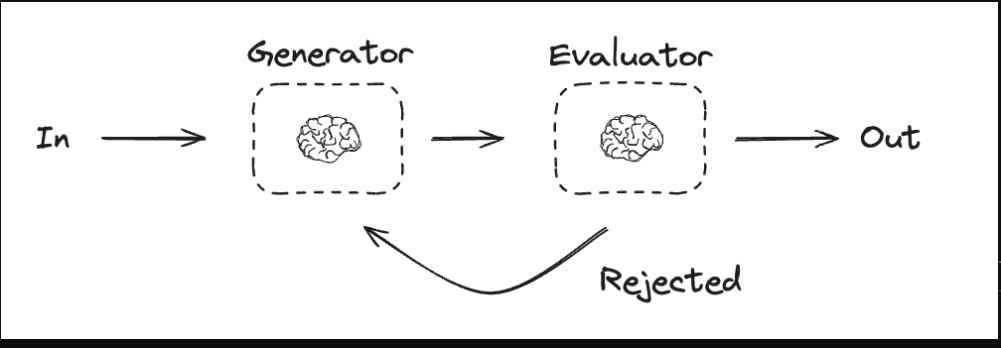

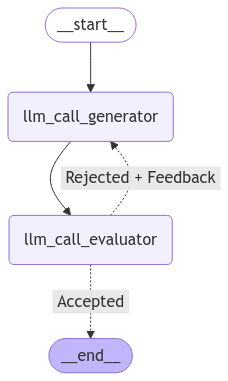

In [18]:
class State(TypedDict):
    joke:str
    topic :str
    feedback:str
    funny_or_not :str


class Feedback(BaseModel):
    grade : Literal['funny','not funny'] = Field(
        description= "Decide if the joke is funny or not"
    )

    feedback : str = Field(
        description="If the joke is not funny , provide feedback on how to improve it"
    )

evaluator = llm.with_structured_output(Feedback)

def llm_call_generator(state : State):
    """LLM generate a joke """

    if state.get('feedback'):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )

    else : 
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state:State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade,"feedback":grade.feedback}

def route_joke(state:State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"]=="funny":
        return "Accepted"
    elif state["funny_or_not"]=="not funny":
        return"Rejected + Feedback" 
    
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)


# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})

In [19]:
print(state["joke"])

Why don't cats make good spies?

Because they're always revealing their paws!
